In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
historical_data = pd.read_csv("data/final_df.csv")
cols = ['Date', 'Open', 'High', 'Low', 'Close', 'GDP (constant 2015 MYR)', 'GDP Growth YOY (%)', 'OPR (%)']
historical_data = historical_data[cols]
historical_data = historical_data[historical_data['Date'] >= '2023-07-01']
historical_data.set_index('Date', inplace=True)
historical_data.info()
historical_data.to_csv("data/historical_data.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 397 entries, 2023-07-01 to 2024-07-31
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Open                     397 non-null    float64
 1   High                     397 non-null    float64
 2   Low                      397 non-null    float64
 3   Close                    397 non-null    float64
 4   GDP (constant 2015 MYR)  397 non-null    float64
 5   GDP Growth YOY (%)       397 non-null    float64
 6   OPR (%)                  397 non-null    float64
dtypes: float64(7)
memory usage: 24.8+ KB


[*********************100%%**********************]  1 of 1 completed

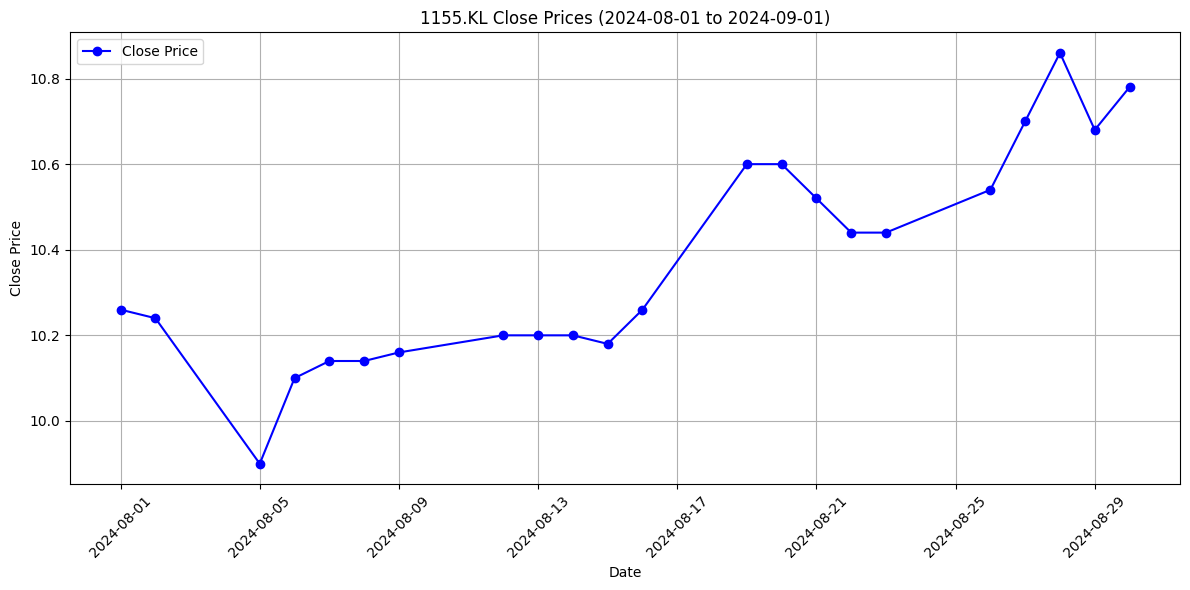

In [6]:
ticker = "1155.KL"  # Replace with your specific stock ticker if necessary
data = yf.download(ticker, start="2024-08-01", end="2024-09-01")

# Plot the Close prices
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], marker='o', linestyle='-', color='blue', label='Close Price')
plt.title(f"{ticker} Close Prices (2024-08-01 to 2024-09-01)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
data['GDP (constant 2015 MYR)'] = 1.804500e+12
data['GDP Growth YOY (%)'] = 3.680282
data['OPR (%)'] = 3.0
# data.columns

# Ensure 'Date' is the index and in datetime format
data.index = pd.to_datetime(data.index)

# Reindex with a complete date range
full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
data = data.reindex(full_date_range)

# Forward-fill missing data
data.fillna(method='ffill', inplace=True)

# Rename the index back to 'Date'
data.index.name = 'Date'

# Debug: Check for missing values and final shape
print("Final Dataset Shape After Forward-Fill:", data.shape)
print("Remaining Missing Values (if any):")
print(data.isna().sum())

data = data.drop(columns=['Adj Close', 'Volume'])
data.to_csv("data/2024_aug_data.csv")


Final Dataset Shape After Forward-Fill: (30, 9)
Remaining Missing Values (if any):
Open                       0
High                       0
Low                        0
Close                      0
Adj Close                  0
Volume                     0
GDP (constant 2015 MYR)    0
GDP Growth YOY (%)         0
OPR (%)                    0
dtype: int64


In [8]:
aug_data = pd.read_csv("data/2024_aug_data.csv")
historical_data = pd.read_csv("data/historical_data.csv")

latest_data = historical_data.append(aug_data, ignore_index=True)
latest_data.set_index('Date', inplace=True)
latest_data.to_csv("data/latest_data.csv")
latest_data.tail(10)

C:\Users\kh\AppData\Local\Temp\ipykernel_19144\3124736061.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latest_data = historical_data.append(aug_data, ignore_index=True)


,Open,High,Low,Close,GDP (constant 2015 MYR),GDP Growth YOY (%),OPR (%)
Date,,,,,,,
2024-08-21,10.60,10.62,10.48,10.52,1.804500e+12,3.680282,3.0
2024-08-22,10.52,10.54,10.40,10.44,1.804500e+12,3.680282,3.0
2024-08-23,10.44,10.54,10.42,10.44,1.804500e+12,3.680282,3.0
2024-08-24,10.44,10.54,10.42,10.44,1.804500e+12,3.680282,3.0
2024-08-25,10.44,10.54,10.42,10.44,1.804500e+12,3.680282,3.0
2024-08-26,10.46,10.58,10.46,10.54,1.804500e+12,3.680282,3.0
2024-08-27,10.54,10.72,10.52,10.70,1.804500e+12,3.680282,3.0
2024-08-28,10.72,11.00,10.72,10.86,1.804500e+12,3.680282,3.0
2024-08-29,10.86,10.94,10.68,10.68,1.804500e+12,3.680282,3.0


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import joblib

# Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Feature Engineering
def add_technical_indicators(df, target):
    """
    Adds technical indicators (MA, EMA, RSI, Bollinger Bands) to the dataset.
    """
    # Moving Averages
    df['MA_50'] = df[target].rolling(window=50).mean()
    df['MA_200'] = df[target].rolling(window=200).mean()
    
    # Exponential Moving Averages
    df['EMA_50'] = df[target].ewm(span=50, adjust=False).mean()
    df['EMA_200'] = df[target].ewm(span=200, adjust=False).mean()
    
    # Relative Strength Index (RSI)
    delta = df[target].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=50).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=50).mean()
    rs = gain / loss
    df['RSI_50'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    rolling_mean = df[target].rolling(window=50).mean()
    rolling_std = df[target].rolling(window=50).std()
    df['BB_upper'] = rolling_mean + (2 * rolling_std)
    df['BB_lower'] = rolling_mean - (2 * rolling_std)

    return df

def add_lagged_features(df, cols, lags):
    """
    Adds lagged versions of specified columns to the dataset.
    """
    for col in cols:
        for lag in lags:
            if col == 'Close':
                df[f'Lagged_{col}_{lag}D'] = df[col].shift(lag)
            else:
                df[f'{col}_Lag_{lag}D'] = df[col].shift(lag)
    return df

class LSTMCNN(nn.Module):
    """
    LSTM-CNN hybrid model for multi-step time series forecasting.
    """
    def __init__(self, input_size, hidden_size, forecast_horizon, num_layers=2, cnn_filters=128, kernel_size=3, dropout=0.2):
        """
        Args:
            input_size: Number of input features.
            hidden_size: Number of hidden units in the LSTM layer.
            forecast_horizon: Number of steps ahead to forecast.
            num_layers: Number of stacked LSTM layers.
            cnn_filters: Number of filters in the CNN layer.
            kernel_size: Size of the convolution kernel.
            dropout: Dropout probability for regularization.
        """
        super(LSTMCNN, self).__init__()
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # CNN Layer
        self.conv = nn.Conv1d(
            in_channels=hidden_size, 
            out_channels=cnn_filters, 
            kernel_size=kernel_size, 
            padding=kernel_size // 2  # To maintain the same spatial size
        )
        
        # Fully Connected Layer
        self.fc = nn.Linear(cnn_filters, forecast_horizon)
        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass for LSTM-CNN model.
        """
        # LSTM output: (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        # Permute for CNN: (batch_size, hidden_size, seq_len)
        lstm_out = lstm_out.permute(0, 2, 1)
        # Apply CNN: (batch_size, cnn_filters, seq_len)
        cnn_out = self.conv(lstm_out)
        # Global Average Pooling: (batch_size, cnn_filters)
        cnn_out = cnn_out.mean(dim=-1)
        # Dropout for regularization
        cnn_out = self.dropout(cnn_out)
        # Fully Connected Layer
        output = self.fc(cnn_out)
        
        return output

# Load Dataset
data = pd.read_csv('data/latest_data.csv')
data.set_index('Date', inplace=True)

# Add Technical Indicators
data = add_technical_indicators(data, target='Close')

# Add Lagged Features
lagged_cols = ['GDP (constant 2015 MYR)', 'OPR (%)', 'Close']
lags = [30, 90, 180, 365]
data = add_lagged_features(data, lagged_cols, lags)

# Drop Rows with NaN (resulting from feature creation)
data.dropna(inplace=True)

print("Dataset Columns After Adding Lagged Features:")
print(data.columns)

# Verify Features Match the Model
features = [
    'Open', 'High', 'Low', 'GDP (constant 2015 MYR)', 'GDP Growth YOY (%)', 
    'OPR (%)', 'MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'RSI_50', 'BB_upper', 
    'BB_lower', 'GDP (constant 2015 MYR)_Lag_30D', 'GDP (constant 2015 MYR)_Lag_90D', 
    'GDP (constant 2015 MYR)_Lag_180D', 'GDP (constant 2015 MYR)_Lag_365D', 
    'OPR (%)_Lag_30D', 'OPR (%)_Lag_90D', 'Lagged_Close_30D', 'Lagged_Close_90D', 
    'Lagged_Close_180D', 'Lagged_Close_365D'
]
missing_features = [col for col in features if col not in data.columns]
if missing_features:
    raise KeyError(f"Missing features in dataset: {missing_features}")

# Step 2: Scaling Features
# Load scalers
feature_scaler = joblib.load('forecast/lstmcnn/feature_scaler.pkl')
target_scaler = joblib.load('forecast/lstmcnn/target_scaler.pkl')

# Scale Features
scaled_features = feature_scaler.transform(data[features])

# Step 3: Prepare Input for Model Inference
seq_len = 30
recent_data = scaled_features[-seq_len:]  # Select last `seq_len` rows
input_sequence = torch.tensor(recent_data, dtype=torch.float32).unsqueeze(0).to(device)  # Move input to device

# Step 4: Load Trained Model
model = torch.load('forecast/lstmcnn/lstmcnn_forecast_model.pth').to(device)
model.eval()

# Step 5: Perform Inference
with torch.no_grad():
    forecast = model(input_sequence).cpu().numpy().flatten()  # Move output back to CPU for further processing

# Step 6: Denormalize Forecast
forecast = target_scaler.inverse_transform(forecast.reshape(-1, 1)).flatten()

# Step 7: Generate Forecast Dates
start_date = pd.to_datetime(data.index[-1])  # Last known date in the dataset
forecast_horizon = len(forecast)
forecast_dates = pd.date_range(start=start_date, periods=forecast_horizon + 1, freq='D')[1:]

# Step 8: Combine Forecast and Dates
forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "Forecasted Close Price": forecast
})

# Output Forecast
print(forecast_df)


Using device: cuda
Dataset Columns After Adding Lagged Features:
Index(['Open', 'High', 'Low', 'Close', 'GDP (constant 2015 MYR)',
       'GDP Growth YOY (%)', 'OPR (%)', 'MA_50', 'MA_200', 'EMA_50', 'EMA_200',
       'RSI_50', 'BB_upper', 'BB_lower', 'GDP (constant 2015 MYR)_Lag_30D',
       'GDP (constant 2015 MYR)_Lag_90D', 'GDP (constant 2015 MYR)_Lag_180D',
       'GDP (constant 2015 MYR)_Lag_365D', 'OPR (%)_Lag_30D',
       'OPR (%)_Lag_90D', 'OPR (%)_Lag_180D', 'OPR (%)_Lag_365D',
       'Lagged_Close_30D', 'Lagged_Close_90D', 'Lagged_Close_180D',
       'Lagged_Close_365D'],
      dtype='object')


C:\Users\kh\AppData\Local\Temp\ipykernel_19144\2028531592.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('forecast/lstmcnn/lstmcnn_forecast_model.p

         Date  Forecasted Close Price
0  2024-08-31               10.387444
1  2024-09-01               10.350754
2  2024-09-02               10.427102
3  2024-09-03               10.385489
4  2024-09-04               10.365139
5  2024-09-05               10.418330
6  2024-09-06               10.339857
7  2024-09-07               10.436493
8  2024-09-08               10.351905
9  2024-09-09               10.383676
10 2024-09-10               10.367358
11 2024-09-11               10.403399
12 2024-09-12               10.330372
13 2024-09-13               10.401539
14 2024-09-14               10.457471
15 2024-09-15               10.422075
16 2024-09-16               10.418697
17 2024-09-17               10.338794
18 2024-09-18               10.366057
19 2024-09-19               10.347007
20 2024-09-20               10.377625
21 2024-09-21               10.329670
22 2024-09-22               10.388444
23 2024-09-23               10.296394
24 2024-09-24               10.406984
25 2024-09-2

[*********************100%%**********************]  1 of 1 completed


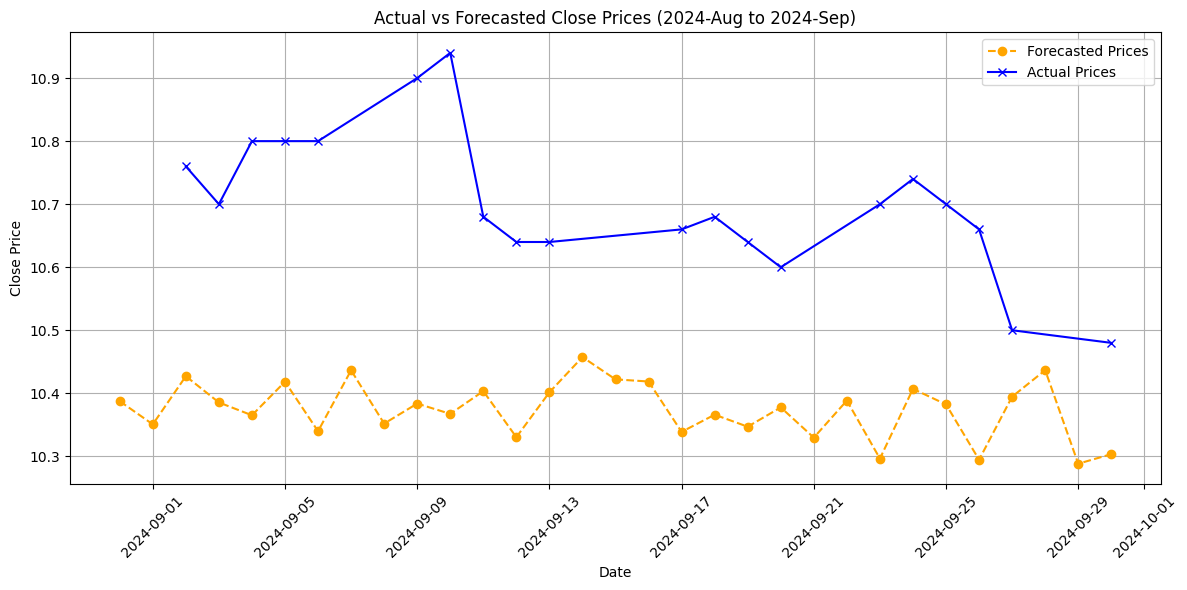

In [10]:
# Get the actual data from Yahoo Finance for the period 2024-August to 2024-September
ticker = "1155.KL"
actual_data = yf.download(ticker, start="2024-09-01", end="2024-10-01")

# Extract actual close prices and dates
actual_prices = actual_data['Close'].values
actual_dates = actual_data.index

# Plot the actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, forecast, label="Forecasted Prices", marker="o", linestyle="--", color="orange")
plt.plot(actual_dates, actual_prices, label="Actual Prices", marker="x", linestyle="-", color="blue")
plt.title("Actual vs Forecasted Close Prices (2024-Aug to 2024-Sep)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Step 1: Fetch Actual Data
ticker = "1155.KL"
actual_data = yf.download(ticker, start="2024-09-01", end="2024-10-01")

# Step 2: Forward-Fill Missing Dates
# Generate a full date range for September 2024
full_date_range = pd.date_range(start="2024-09-01", end="2024-09-30", freq="D")

# Reindex the actual data to include all dates in the range and forward-fill missing values
actual_data = actual_data.reindex(full_date_range, method="ffill")

# Extract forward-filled close prices and dates
actual_prices = actual_data['Close'].values
actual_dates = actual_data.index

# Step 3: Debugging Outputs
print("Actual Data After Forward Fill:")
print(actual_data.head())
print("\nDates after Forward Fill:")
print(actual_dates)


[*********************100%%**********************]  1 of 1 completed

Actual Data After Forward Fill:
             Open   High    Low  Close  Adj Close      Volume
2024-09-01    NaN    NaN    NaN    NaN        NaN         NaN
2024-09-02  10.78  10.80  10.66  10.76  10.474771   9546700.0
2024-09-03  10.76  10.82  10.66  10.70  10.416362  10840000.0
2024-09-04  10.70  10.82  10.68  10.80  10.513712  23271800.0
2024-09-05  10.80  10.84  10.78  10.80  10.513712  17008300.0

Dates after Forward Fill:
DatetimeIndex(['2024-09-01', '2024-09-02', '2024-09-03', '2024-09-04',
               '2024-09-05', '2024-09-06', '2024-09-07', '2024-09-08',
               '2024-09-09', '2024-09-10', '2024-09-11', '2024-09-12',
               '2024-09-13', '2024-09-14', '2024-09-15', '2024-09-16',
               '2024-09-17', '2024-09-18', '2024-09-19', '2024-09-20',
               '2024-09-21', '2024-09-22', '2024-09-23', '2024-09-24',
               '2024-09-25', '2024-09-26', '2024-09-27', '2024-09-28',
               '2024-09-29', '2024-09-30'],
              dtype='datetim

C:\Users\kh\AppData\Local\Temp\ipykernel_19144\1434558809.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('forecast/lstmcnn/lstmcnn_forecast_model.p

Dataset Columns After Adding Lagged Features:
Index(['Open', 'High', 'Low', 'Close', 'GDP (constant 2015 MYR)',
       'GDP Growth YOY (%)', 'OPR (%)', 'MA_50', 'MA_200', 'EMA_50', 'EMA_200',
       'RSI_50', 'BB_upper', 'BB_lower', 'GDP (constant 2015 MYR)_Lag_30D',
       'GDP (constant 2015 MYR)_Lag_90D', 'GDP (constant 2015 MYR)_Lag_180D',
       'GDP (constant 2015 MYR)_Lag_365D', 'OPR (%)_Lag_30D',
       'OPR (%)_Lag_90D', 'OPR (%)_Lag_180D', 'OPR (%)_Lag_365D',
       'Lagged_Close_30D', 'Lagged_Close_90D', 'Lagged_Close_180D',
       'Lagged_Close_365D'],
      dtype='object')
Evaluation Metrics:
Mean Absolute Error (MAE): 0.2850
Mean Squared Error (MSE): 0.1033
Root Mean Squared Error (RMSE): 0.3215
Mean Absolute Percentage Error (MAPE): 2.70%


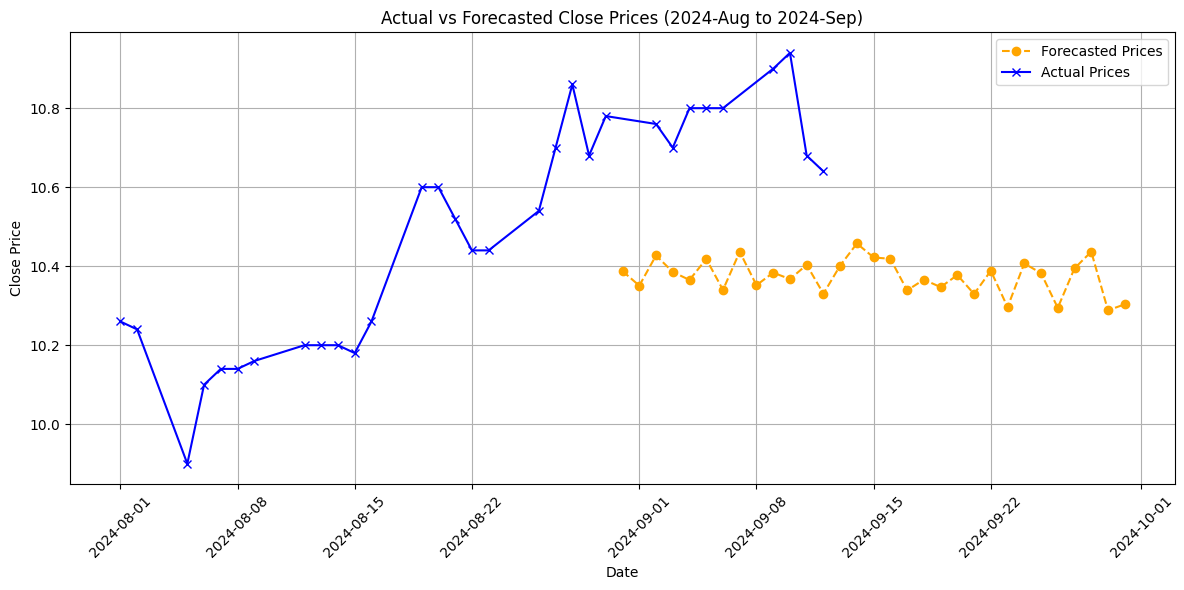

In [12]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import torch.nn as nn
import joblib

# Step 1: Feature Engineering
def add_technical_indicators(df, target):
    """
    Adds technical indicators (MA, EMA, RSI, Bollinger Bands) to the dataset.
    """
    # Moving Averages
    df['MA_50'] = df[target].rolling(window=50).mean()
    df['MA_200'] = df[target].rolling(window=200).mean()
    
    # Exponential Moving Averages
    df['EMA_50'] = df[target].ewm(span=50, adjust=False).mean()
    df['EMA_200'] = df[target].ewm(span=200, adjust=False).mean()
    
    # Relative Strength Index (RSI)
    delta = df[target].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=50).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=50).mean()
    rs = gain / loss
    df['RSI_50'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    rolling_mean = df[target].rolling(window=50).mean()
    rolling_std = df[target].rolling(window=50).std()
    df['BB_upper'] = rolling_mean + (2 * rolling_std)
    df['BB_lower'] = rolling_mean - (2 * rolling_std)

    return df

def add_lagged_features(df, cols, lags):
    """
    Adds lagged versions of specified columns to the dataset.
    """
    for col in cols:
        for lag in lags:
            if col == 'Close':
                df[f'Lagged_{col}_{lag}D'] = df[col].shift(lag)
            else:
                df[f'{col}_Lag_{lag}D'] = df[col].shift(lag)
    return df

class LSTMCNN(nn.Module):
    """
    LSTM-CNN hybrid model for multi-step time series forecasting.
    """
    def __init__(self, input_size, hidden_size, forecast_horizon, num_layers=2, cnn_filters=128, kernel_size=3, dropout=0.2):
        """
        Args:
            input_size: Number of input features.
            hidden_size: Number of hidden units in the LSTM layer.
            forecast_horizon: Number of steps ahead to forecast.
            num_layers: Number of stacked LSTM layers.
            cnn_filters: Number of filters in the CNN layer.
            kernel_size: Size of the convolution kernel.
            dropout: Dropout probability for regularization.
        """
        super(LSTMCNN, self).__init__()
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # CNN Layer
        self.conv = nn.Conv1d(
            in_channels=hidden_size, 
            out_channels=cnn_filters, 
            kernel_size=kernel_size, 
            padding=kernel_size // 2  # To maintain the same spatial size
        )
        
        # Fully Connected Layer
        self.fc = nn.Linear(cnn_filters, forecast_horizon)
        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass for LSTM-CNN model.
        """
        # LSTM output: (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        # Permute for CNN: (batch_size, hidden_size, seq_len)
        lstm_out = lstm_out.permute(0, 2, 1)
        # Apply CNN: (batch_size, cnn_filters, seq_len)
        cnn_out = self.conv(lstm_out)
        # Global Average Pooling: (batch_size, cnn_filters)
        cnn_out = cnn_out.mean(dim=-1)
        # Dropout for regularization
        cnn_out = self.dropout(cnn_out)
        # Fully Connected Layer
        output = self.fc(cnn_out)
        
        return output

# Load Dataset
data = pd.read_csv('data/latest_data.csv')
data.set_index('Date', inplace=True)

# Add Technical Indicators
data = add_technical_indicators(data, target='Close')

# Add Lagged Features
lagged_cols = ['GDP (constant 2015 MYR)', 'OPR (%)', 'Close']
lags = [30, 90, 180, 365]
data = add_lagged_features(data, lagged_cols, lags)

# Drop Rows with NaN (resulting from feature creation)
data.dropna(inplace=True)

print("Dataset Columns After Adding Lagged Features:")
print(data.columns)

# Verify Features Match the Model
features = [
    'Open', 'High', 'Low', 'GDP (constant 2015 MYR)', 'GDP Growth YOY (%)', 
    'OPR (%)', 'MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'RSI_50', 'BB_upper', 
    'BB_lower', 'GDP (constant 2015 MYR)_Lag_30D', 'GDP (constant 2015 MYR)_Lag_90D', 
    'GDP (constant 2015 MYR)_Lag_180D', 'GDP (constant 2015 MYR)_Lag_365D', 
    'OPR (%)_Lag_30D', 'OPR (%)_Lag_90D', 'Lagged_Close_30D', 'Lagged_Close_90D', 
    'Lagged_Close_180D', 'Lagged_Close_365D'
]
missing_features = [col for col in features if col not in data.columns]
if missing_features:
    raise KeyError(f"Missing features in dataset: {missing_features}")

# Step 2: Scaling Features
# Load scalers
feature_scaler = joblib.load('forecast/lstmcnn/feature_scaler.pkl')
target_scaler = joblib.load('forecast/lstmcnn/target_scaler.pkl')

# Scale Features
scaled_features = feature_scaler.transform(data[features])

# Step 3: Prepare Input for Model Inference
seq_len = 30
recent_data = scaled_features[-seq_len:]  # Select last `seq_len` rows
input_sequence = torch.tensor(recent_data, dtype=torch.float32).unsqueeze(0).to(device)  # Move input to device

# Load the trained model
model = torch.load('forecast/lstmcnn/lstmcnn_forecast_model.pth').to(device)
model.eval()

# Perform model inference
with torch.no_grad():
    forecast = model(input_sequence).cpu().numpy().flatten()

# Denormalize the forecast
forecast = target_scaler.inverse_transform(forecast.reshape(-1, 1)).flatten()

# Generate forecast dates
start_date = pd.to_datetime(data.index[-1])  # Last known date in the dataset
forecast_horizon = len(forecast)
forecast_dates = pd.date_range(start=start_date, periods=forecast_horizon + 1, freq='D')[1:]

# Get the actual data from Yahoo Finance for the period 2024-August to 2024-September
ticker = "1155.KL"
actual_data = yf.download(ticker, start="2024-08-01", end="2024-10-01")

# Extract actual close prices and dates
actual_prices = actual_data['Close'].values
actual_dates = actual_data.index

# Align forecasted dates with actual dates
if len(actual_prices) > len(forecast):
    actual_prices = actual_prices[:len(forecast)]
    actual_dates = actual_dates[:len(forecast)]
elif len(forecast) > len(actual_prices):
    forecast = forecast[:len(actual_prices)]
    forecast_dates = forecast_dates[:len(actual_prices)]

# Calculate Evaluation Metrics
mae = mean_absolute_error(actual_prices, forecast)
mse = mean_squared_error(actual_prices, forecast)
rmse = mean_squared_error(actual_prices, forecast, squared=False)  # RMSE = sqrt(MSE)
mape = (np.mean(np.abs((actual_prices - forecast) / actual_prices))) * 100

# Print Evaluation Metrics
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot the actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, forecast, label="Forecasted Prices", marker="o", linestyle="--", color="orange")
plt.plot(actual_dates, actual_prices, label="Actual Prices", marker="x", linestyle="-", color="blue")
plt.title("Actual vs Forecasted Close Prices (2024-Aug to 2024-Sep)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\kh\AppData\Local\Temp\ipykernel_19144\3243377330.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("forecast/rnn/rnn2_forecast_model.pth").to

Using device: cuda
Dataset Columns After Adding Lagged Features:
Index(['Open', 'High', 'Low', 'Close', 'GDP (constant 2015 MYR)',
       'GDP Growth YOY (%)', 'OPR (%)', 'MA_50', 'MA_200', 'EMA_50', 'EMA_200',
       'RSI_50', 'BB_upper', 'BB_lower', 'GDP (constant 2015 MYR)_Lag_30D',
       'GDP (constant 2015 MYR)_Lag_90D', 'GDP (constant 2015 MYR)_Lag_180D',
       'GDP (constant 2015 MYR)_Lag_365D', 'OPR (%)_Lag_30D',
       'OPR (%)_Lag_90D', 'OPR (%)_Lag_180D', 'OPR (%)_Lag_365D',
       'Lagged_Close_30D', 'Lagged_Close_90D', 'Lagged_Close_180D',
       'Lagged_Close_365D'],
      dtype='object')
Evaluation Metrics:
Mean Absolute Error (MAE): 0.2239
Mean Squared Error (MSE): 0.0592
Root Mean Squared Error (RMSE): 0.2434
Mean Absolute Percentage Error (MAPE): 2.09%


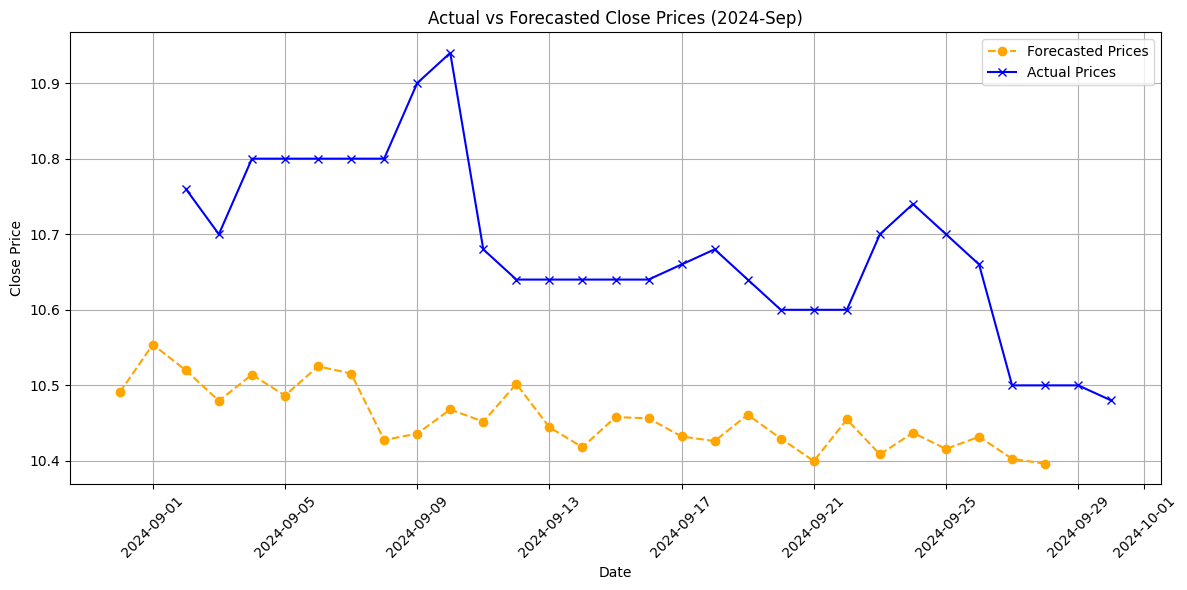

In [14]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 2: Define Helper Functions
def denormalize(predictions, scaler):
    """
    Denormalize predictions using the target scaler.
    """
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

def add_technical_indicators(df, target):
    """
    Adds technical indicators (MA, EMA, RSI, Bollinger Bands) to the dataset.
    """
    # Moving Averages
    df['MA_50'] = df[target].rolling(window=50).mean()
    df['MA_200'] = df[target].rolling(window=200).mean()
    
    # Exponential Moving Averages
    df['EMA_50'] = df[target].ewm(span=50, adjust=False).mean()
    df['EMA_200'] = df[target].ewm(span=200, adjust=False).mean()
    
    # Relative Strength Index (RSI)
    delta = df[target].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=50).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=50).mean()
    rs = gain / loss
    df['RSI_50'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    rolling_mean = df[target].rolling(window=50).mean()
    rolling_std = df[target].rolling(window=50).std()
    df['BB_upper'] = rolling_mean + (2 * rolling_std)
    df['BB_lower'] = rolling_mean - (2 * rolling_std)

    return df

def add_lagged_features(df, cols, lags):
    """
    Adds lagged versions of specified columns to the dataset.
    """
    for col in cols:
        for lag in lags:
            if col == 'Close':
                df[f'Lagged_{col}_{lag}D'] = df[col].shift(lag)
            else:
                df[f'{col}_Lag_{lag}D'] = df[col].shift(lag)
    return df

class RNNForecastModel(nn.Module):
    """
    Vanilla RNN model for multi-step forecasting.
    """
    def __init__(self, input_size, hidden_size, forecast_horizon, num_layers=3, dropout=0.3):
        super(RNNForecastModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh', dropout=dropout)
        self.fc = nn.Linear(hidden_size, forecast_horizon)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

# Load Dataset
data = pd.read_csv('data/latest_data.csv')
data.set_index('Date', inplace=True)

# Add Technical Indicators
data = add_technical_indicators(data, target='Close')

# Add Lagged Features
lagged_cols = ['GDP (constant 2015 MYR)', 'OPR (%)', 'Close']
lags = [30, 90, 180, 365]
data = add_lagged_features(data, lagged_cols, lags)

# Drop Rows with NaN (resulting from feature creation)
data.dropna(inplace=True)

print("Dataset Columns After Adding Lagged Features:")
print(data.columns)

# Load trained scalers
feature_scaler = joblib.load("forecast/rnn/feature2_scaler.pkl")
target_scaler = joblib.load("forecast/rnn/target2_scaler.pkl")

# Define features
features = [
    "Open", "High", "Low", "GDP (constant 2015 MYR)", "GDP Growth YOY (%)",
    "OPR (%)", "MA_50", "MA_200", "EMA_50", "EMA_200", "RSI_50", "BB_upper",
    "BB_lower", "GDP (constant 2015 MYR)_Lag_30D", "GDP (constant 2015 MYR)_Lag_90D",
    "GDP (constant 2015 MYR)_Lag_180D", "GDP (constant 2015 MYR)_Lag_365D",
    "OPR (%)_Lag_30D", "OPR (%)_Lag_90D", "Lagged_Close_30D", "Lagged_Close_90D",
    "Lagged_Close_180D", "Lagged_Close_365D"
]

# Scale features
scaled_features = feature_scaler.transform(data[features])

# Step 4: Prepare Input for Model Inference
seq_len = 30
recent_data = scaled_features[-seq_len:]  # Select last `seq_len` rows
input_sequence = torch.tensor(recent_data, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Step 5: Load Trained Model
model = torch.load("forecast/rnn/rnn2_forecast_model.pth").to(device)
model.eval()

# Step 6: Perform Inference
with torch.no_grad():
    forecast = model(input_sequence).cpu().numpy().flatten()  # Move output back to CPU

# Step 7: Denormalize the Forecast
forecast = denormalize(forecast, target_scaler)

# Generate forecast dates
start_date = pd.to_datetime(data.index[-1])  # Last known date in the dataset
forecast_horizon = len(forecast)
forecast_dates = pd.date_range(start=start_date, periods=forecast_horizon + 1, freq="D")[1:]

# Step 8: Fetch and Forward-Fill Actual Data
ticker = "1155.KL"
actual_data = yf.download(ticker, start="2024-09-01", end="2024-10-01")

# Forward-fill missing dates
full_date_range = pd.date_range(start="2024-09-01", end="2024-09-30", freq="D")
actual_data = actual_data.reindex(full_date_range, method="ffill")

# Extract actual prices and dates
actual_prices = actual_data["Close"].values
actual_dates = actual_data.index

# Step 9: Handle NaN in Actual Prices
# Remove rows where actual prices are NaN
valid_indices = ~np.isnan(actual_prices)
actual_prices = actual_prices[valid_indices]
actual_dates = actual_dates[valid_indices]

# Ensure forecast and actual are aligned
if len(forecast) > len(actual_prices):
    forecast = forecast[:len(actual_prices)]
    forecast_dates = forecast_dates[:len(actual_prices)]
elif len(actual_prices) > len(forecast):
    actual_prices = actual_prices[:len(forecast)]
    actual_dates = actual_dates[:len(forecast)]

# Step 10: Evaluate Metrics
mae = mean_absolute_error(actual_prices, forecast)
mse = mean_squared_error(actual_prices, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_prices - forecast) / actual_prices)) * 100

# Print Evaluation Metrics
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Step 11: Plot Actual vs Forecast
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, forecast, label="Forecasted Prices", marker="o", linestyle="--", color="orange")
plt.plot(actual_dates, actual_prices, label="Actual Prices", marker="x", linestyle="-", color="blue")
plt.title("Actual vs Forecasted Close Prices (2024-Sep)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
